className = 'grid_Strategy'

author = 'sky'

这是一个上涨型网格策略，20均线与80均线金叉为做多信号，20均线与80均线空头排列则清仓离场

网格设置5%的价差，首次开仓50手，允许加仓5次，仓位在 0--100直接波动

In [4]:
# coding: utf-8
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate,
                                                     BarGenerator,
                                                     ArrayManager)
from collections import defaultdict
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
class grid_Strategy(CtaTemplate):
    #网格策略
    className = 'grid_Strategy'
    author = 'sky'
    
    symbol = EMPTY_STRING  
    
    # 策略变量
    posSize = 1                     # 每笔下单的数量

    fastWindow = 20    # 快速均线参数
    slowWindow = 80     # 慢速均线参数
    
    stopRatio = 0.06   # 止损比例
    fixsize = 1
    transactionPrice = EMPTY_FLOAT # 记录成交价格

    wave = EMPTY_FLOAT
    ##########
    
        # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'symbol',
                'fastWindow',
                 'slowWindow',
                 'stopRatio',
                 'profitMultiplier']   
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
              'transactionPrice',
              'maTrend']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict',
                'eveningDict',
                'bondDict']
    
    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(grid_Strategy, self).__init__(ctaEngine, setting)
        
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'海龟策略初始化')
        # 初始化仓位字典
        self.symbol = self.symbolList[0]  
        
        self.generateBarDict(self.onBar)  
        self.generateBarDict(self.onBar,30,self.on30MinBar,size =100)
        
        if self.ctaEngine.engineType == 'trading':
            # 实盘载入1分钟历史数据，并采用回放计算的方式初始化策略参数
            # 通用可选参数：["1min","5min","15min","30min","60min","4hour","1day","1week","1month"]
            pastbar1 = self.loadHistoryBar(self.Symbol,
                                type_ = "1min",  size = 1000)


            # 更新数据矩阵(optional)
            for bar1 in zip (pastbar1):    
                self.amDict[self.symbol].updateBar(bar1)    
        
        elif self.ctaEngine.engineType == 'backtesting':
            # 获取回测设置中的initHours长度的历史数据
            self.initBacktesingData()    
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'网格策略初始化')
        #print('start',file=test)
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
    
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.writeCtaLog('stg_onbar_check_%s_%s_%s'%(bar.vtSymbol,bar.datetime,bar.close))
        
        self.bg30Dict[bar.vtSymbol].updateBar(bar)
        am = self.am30Dict[self.symbol]
            
        fastMa = ta.MA(am.close, self.fastWindow)
        slowMa = ta.MA(am.close, self.slowWindow)
        
        
#         if (self.posDict[self.symbol+"_LONG"]+self.posDict[self.symbol+"_SHORT"] > 0) and (self.posDict[self.symbol+"_LONG"]+self.posDict[self.symbol+"_SHORT"] <= 100):
#             if self.wave == 1:
#                 self.cover(self.symbol, bar.close, self.posDict[self.symbol+"_SHORT"], priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
#                 print('平空清仓出场，止损价格%s，出场手数：%s,止损时间%s'%(bar.close,self.posDict[self.symbol+"_SHORT"],bar.datetime))
#                 self.sell(self.symbol, bar.close, self.posDict[self.symbol+"_LONG"], priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
#                 print('平多清仓出场，止损价格%s，出场手数：%s,止损时间%s'%(bar.close,self.posDict[self.symbol+"_LONG"],bar.datetime))
#             else:
#                 n = int(20*(bar.close-self.transactionPrice)/self.transactionPrice)
#                 if (n<0 and n>=-5):
#                     if self.posDict[self.symbol+"_LONG"] != 0:
#                         self.sell(self.symbol, bar.close, 10*abs(n) ,priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
#                     else:
#                         self.cover(self.symbol, bar.close, 10*abs(n) ,priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
#                         print('网格平空，价格%s，止损时间%s，手数：%s'%(bar.close,bar.datetime,10*abs(n)))
#                     if (self.posDict[self.symbol+"_SHORT"] == 0) and (self.posDict[self.symbol+"_LONG"] == 0):
#                         if self.wave == 0:
#                             self.short(self.symbol, bar.close, 50, priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
#                 elif (n>0 and n<5):
#                     self.buy(self.symbol, bar.close, 10*n, priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
#                     print('网格加仓，价格%s，时间%s，手数：%s'%(bar.close,bar.datetime,10*abs(n)))

##每次开仓开50手，仓位控制在100手以内，也就是做多加5次仓位


        if (self.posDict[self.symbol+"_LONG"]>0) and (self.posDict[self.symbol+"_LONG"]<=100):
        ####  先判断有没有达到止损清仓条件
            if self.wave == 1:
                self.sell(self.symbol, bar.close, self.posDict[self.symbol+"_LONG"], priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
                print('平多清仓出场，止损价格%s，出场手数：%s,止损时间%s'%(bar.close,self.posDict[self.symbol+"_LONG"],bar.datetime))
            else:
        ####   计算网格差，这里设置5%
                n = int(20*(bar.close-self.transactionPrice)/self.transactionPrice) 
                if (n>0 and n<=5):
                    self.sell(self.symbol, bar.close, 10*abs(n) ,priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
                    print('网格平空，价格%s，止损时间%s，手数：%s'%(bar.close,bar.datetime,10*abs(n)))
                    if (self.posDict[self.symbol+"_SHORT"] == 0) and (self.posDict[self.symbol+"_LONG"] == 0):
                        if self.wave == 0:
                            self.buy(self.symbol, bar.close, 50, priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
                elif (n<0 and n>=-5):
                    self.buy(self.symbol, bar.close, 10*abs(n), priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
                    print('网格加仓，价格%s，时间%s，手数：%s'%(bar.close,bar.datetime,10*abs(n)))
                
    
    def on30MinBar(self, bar):
        """15分钟K线推送"""
#         print(self.posDict)
        self.writeCtaLog('stg_on30Minbar_check_%s_%s_%s'%(bar.vtSymbol,bar.datetime,self.am30Dict[bar.vtSymbol].close))
        
        self.am30Dict[bar.vtSymbol].updateBar(bar)
        
        am30 = self.am30Dict[self.symbol]

        fastMa = ta.MA(am30.close, self.fastWindow)
        
        slowMa = ta.MA(am30.close, self.slowWindow)

        
        if slowMa[-2]>slowMa[-1] and fastMa[-2]>fastMa[-1]:  ##  平仓条件，空头排列
            self.wave = 1
        else:
            self.wave = 0
        
        
        if fastMa[-2] < slowMa[-2] and fastMa[-1] > slowMa[-1]:    ####开仓条件   金叉
            self.Trend = 1
        else:
            self.Trend = 0
            
        if self.posDict[self.symbol+"_LONG"] == 0:
            if self.Trend == 1:###############   金叉进场，开多仓
                self.buy(self.symbol, bar.close , 50 ,priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
                print('开多仓，价格：%s，时间%s,手数:%s'%(bar.close,bar.datetime,50))

                
#         if (self.posDict[self.symbol+"_LONG"] == 0) and (self.posDict[self.symbol+"_SHORT"] == 0):
#             if self.Trend == 1:
#                 self.short(self.symbol, 1 , 50 ,priceType = PRICETYPE_LIMITPRICE,levelRate = 10)
#                 print('开空仓，价格：%s，时间%s,手数:%s'%(bar.close,bar.datetime,50))
#                 print('仓位：%s'%self.posDict[self.symbol+"_LONG"])
        
    
        ######### 计算策略需要的信号-------------------------------------------------####################################        

        
        self.putEvent()

    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        self.transactionPrice = trade.price
        #print('price:%s, direction:%s,offset:%s,self.Cross:%s,tradeVolume: %s'
                #%(trade.price, trade.direction, trade.offset,self.Cross,trade.volume),file=test0)
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0} 
可平仓量: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
2018-09-20 02:19:58.447874	开始回测
2018-09-20 02:19:58.447874	策略初始化
2018-09-20 02:19:58.447874	载入历史数据。数据范围:[20180814 01:01,20180814 02:01)
2018-09-20 02:19:58.521828	We use full range of local data in EOSUSDT:binance 
2018-09-20 02:19:58.521828	载入完成，数据量：60
2018-09-20 02:19:58.526827	策略初始化完成
2018-09-20 02:19:58.526827	策略启动完成
2018-09-20 02:19:58.526827	开始回放回测数据,回测范围:[20180814 02:01,20180903 09:01)
2018-09-20 02:19:58.530824	载入历史数据。数据范围:[20180814 02:01,20180903 09:01)
2018-09-20 02:20:03.952548	We use full range of local data in EOSUSDT:binance 
2018-09-20 02:20:03.976533	载入完成，数据量：29220
2018-09-20 02:20:03.977533	当前回放数据:[20180814 02:01,20180903 09:01)
开多仓，价格：4.9395，时间2018-08-17 15:30:00,手数:50   
网格平空，价格5.1933，止损时间2018-08-18 00:52:00，手数：10 
网格平空，价格5.4694，止损时间2018-08-18 05:47:00，手数：10 
网格加仓，价格5.1959，时间2018-08-18 14:57:00，手数：10   
网格平空，价格5.4539，止损时间2018-08-18 19

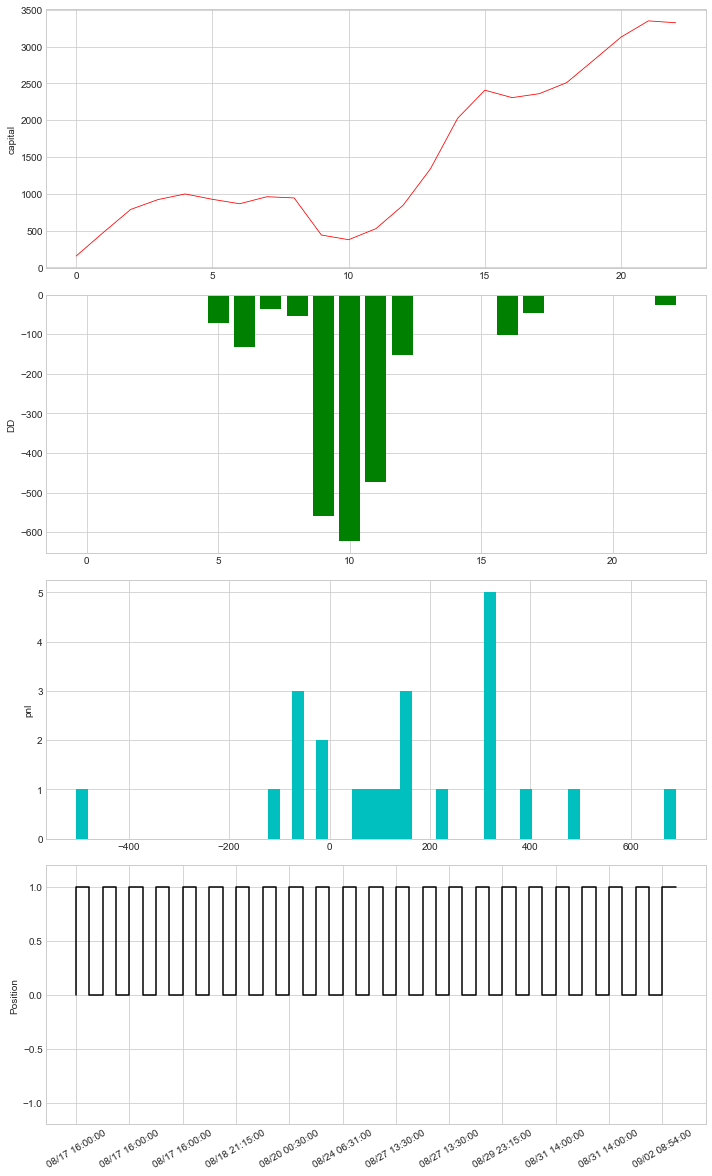

2018-09-20 02:20:07.872143	计算按日统计结果
2018-09-20 02:20:07.904120	------------------------------
2018-09-20 02:20:07.904120	首个交易日：	2018-08-14 00:00:00
2018-09-20 02:20:07.904120	最后交易日：	2018-09-03 00:00:00
2018-09-20 02:20:07.904120	总交易日：	21
2018-09-20 02:20:07.904120	盈利交易日	7
2018-09-20 02:20:07.904120	亏损交易日：	6
2018-09-20 02:20:07.904120	起始资金：	1000000
2018-09-20 02:20:07.904120	结束资金：	1,017,957.63
2018-09-20 02:20:07.904120	总收益率：	1.8%
2018-09-20 02:20:07.904120	年化收益：	20.52%
2018-09-20 02:20:07.904120	总盈亏：	17,957.63
2018-09-20 02:20:07.905120	最大回撤: 	-2,979.07
2018-09-20 02:20:07.905120	百分比最大回撤: -0.3%
2018-09-20 02:20:07.905120	总手续费：	34.87
2018-09-20 02:20:07.905120	总滑点：	21.6
2018-09-20 02:20:07.905120	总成交金额：	1,162,379.1
2018-09-20 02:20:07.905120	总成交笔数：	29
2018-09-20 02:20:07.905120	日均盈亏：	855.13
2018-09-20 02:20:07.905120	日均手续费：	1.66
2018-09-20 02:20:07.905120	日均滑点：	1.03
2018-09-20 02:20:07.905120	日均成交金额：	55,351.39
2018-09-20 02:20:07.905120	日均成交笔数：	1.38
2018-09-20 02:20:07.905120	日均收益率：	0.0

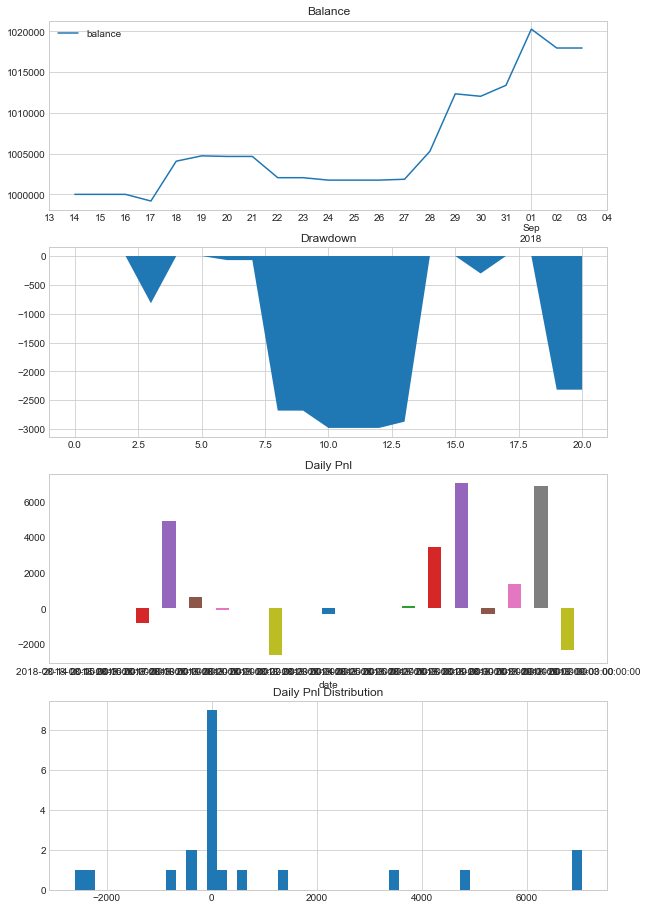

In [5]:
from __future__ import division
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine
from vnpy.trader.app.ctaStrategy.ctaBase import *

if __name__ == '__main__':
    # 创建回测引擎
    engine = BacktestingEngine()
    # 设置引擎的回测模式为K线
    engine.setBacktestingMode(engine.BAR_MODE)

    # 设置回测用的数据起始日期
    engine.setStartDate('20180814 02:01',initHours=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180903 09:01')
    # 设置产品相关参数
    engine.setSlippage(0.0001)     # 设置滑点为股指1跳
    engine.setRate(0.3/10000)   # 设置手续费万0.3
    engine.setSize(300)         # 设置股指合约大小
    engine.setPriceTick(0.0001)    # 设置股指最小价格变动
    engine.setCapital(1000000)  # 设置回测本金
    
    # 设置使用的历史数据库
    engine.setDatabase(MINUTE_DB_NAME)
    
    # 在引擎中创建策略对象
    d = {'symbolList':['EOSUSDT:binance']}
    engine.initStrategy(wangge_Strategy, d)
    
    # 开始跑回测
    engine.runBacktesting()
    # 输出策略的回测日志
    import pandas as pd
    from datetime import datetime
    import os 
    log = engine.logList
    dataframe = pd.DataFrame(log)
    filename = 'BTG_' + datetime.now().strftime("%Y%m%d_%H%M%S") +'.csv'
    filename = os.path.abspath(filename) 
    dataframe.to_csv(filename,index=False,sep=',')    
    # 显示回测结果
    engine.showBacktestingResult()
    engine.showDailyResult()